In [84]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [85]:
# Data Loading with Feature Extraction
DATASET_PATH = r"C:\Users\mariam mohamed\Downloads\Rotten_Tomato_Detection\two_classes"
IMG_SIZE = 80
data = []
labels = []
categories = {"Fresh": 1, "Rotten": 0}

for category, label in categories.items():
    folder_path = os.path.join(DATASET_PATH, category)

    if not os.path.exists(folder_path):
        print(f"ERROR: Folder '{category}' not found")
        continue

    file_names = os.listdir(folder_path)
    print(f"Loading {category}: {len(file_names)} files")

    for filename in file_names:
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype(np.float32) / 255.0

            # HOG Features
            hog_features_list = []
            for channel in range(3):
                hog_feat = hog(img[:, :, channel], orientations=9,
                              pixels_per_cell=(8, 8), cells_per_block=(2, 2))
                hog_features_list.append(hog_feat)

            combined_hog = np.concatenate(hog_features_list)

            # Color Features
            color_features = []
            for channel in range(3):
                color_features.append(np.mean(img[:, :, channel]))
                color_features.append(np.std(img[:, :, channel]))

            img_hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2HSV)
            img_hsv = img_hsv.astype(np.float32) / 255.0

            for channel in range(3):
                color_features.append(np.mean(img_hsv[:, :, channel]))
                color_features.append(np.std(img_hsv[:, :, channel]))

            final_features = np.concatenate([combined_hog, np.array(color_features)])

            data.append(final_features)
            labels.append(label)

df = pd.DataFrame(data)
df['label'] = labels
print(f"\nTotal samples: {df.shape[0]}")
print(f"Total features: {df.shape[1] - 1}")
print(df['label'].value_counts())


Loading Fresh: 1421 files
Loading Rotten: 793 files

Total samples: 2214
Total features: 8760
label
1    1421
0     793
Name: count, dtype: int64


In [86]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,8751,8752,8753,8754,8755,8756,8757,8758,8759,label
0,0.107536,0.006886,0.001670,0.021332,0.191504,0.088468,0.234426,0.167461,0.104451,0.208015,...,0.110546,0.325775,0.161216,0.221949,0.215930,0.108533,0.170367,0.329301,0.159843,1
1,0.166616,0.051991,0.040816,0.045537,0.129720,0.085342,0.117331,0.237669,0.117568,0.171432,...,0.104805,0.341010,0.184529,0.198608,0.189543,0.151988,0.229333,0.345163,0.181548,1
2,0.186532,0.019608,0.041896,0.056768,0.112479,0.191576,0.120302,0.229856,0.163954,0.209780,...,0.120567,0.375323,0.165848,0.244846,0.225780,0.109908,0.178790,0.379458,0.163318,1
3,0.184078,0.052687,0.038335,0.000000,0.204050,0.117909,0.231190,0.231190,0.113927,0.142899,...,0.125714,0.393448,0.167526,0.244797,0.221549,0.109232,0.180263,0.398018,0.164718,1
4,0.139003,0.000000,0.004043,0.013182,0.194563,0.079771,0.142488,0.154008,0.117057,0.265566,...,0.105690,0.327363,0.187717,0.211258,0.181737,0.150420,0.222030,0.332471,0.183908,1


In [87]:
df.shape

(2214, 8761)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214 entries, 0 to 2213
Columns: 8761 entries, 0 to label
dtypes: float32(8760), int64(1)
memory usage: 74.0 MB


In [89]:
print(df.isnull().sum())  # check for missing values

0        0
1        0
2        0
3        0
4        0
        ..
8756     0
8757     0
8758     0
8759     0
label    0
Length: 8761, dtype: int64


In [90]:
#Dataset Information
num_classes = len(categories)
class_labels = categories

total_samples = len(df)
img_height = IMG_SIZE
img_width = IMG_SIZE
num_features = df.shape[1] - 1


print("Dataset Details:")

print(f"Number of classes: {num_classes}")
print(f"Class labels: {class_labels}")
print(f"Total number of samples: {total_samples}")
print(f"Original image size: {img_height} x {img_width}")
print(f"Total extracted features: {num_features}")


Dataset Details:
Number of classes: 2
Class labels: {'Fresh': 1, 'Rotten': 0}
Total number of samples: 2214
Original image size: 80 x 80
Total extracted features: 8760


In [91]:
X = df.drop('label', axis=1)
y = df['label']

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (2214, 8760)
Labels shape: (2214,)


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

print("Train/Test Split:")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Train/Test Split:
Training samples: 1771
Testing samples: 443


In [93]:
print("Training set distribution:")
print(y_train.value_counts())
print("\nTest set distribution:")
print(y_test.value_counts())

Training set distribution:
label
1    1137
0     634
Name: count, dtype: int64

Test set distribution:
label
1    284
0    159
Name: count, dtype: int64


In [94]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Using StandardScaler (Z-score Normalization)")
print(f"Training data mean: {X_train_scaled.mean():.6f}")
print(f"Training data std: {X_train_scaled.std():.6f}")
print(f"Training data min: {X_train_scaled.min():.4f}")
print(f"Training data max: {X_train_scaled.max():.4f}")

Using StandardScaler (Z-score Normalization)
Training data mean: 0.000000
Training data std: 1.000000
Training data min: -11.4836
Training data max: 14.7133


In [95]:
X_train_scaled[:5]

array([[-0.7584932 , -0.65446246, -0.5530293 , ...,  0.2236206 ,
        -0.3497868 , -0.783901  ],
       [ 2.043728  ,  1.099678  ,  0.2384373 , ..., -0.6028468 ,
         0.12362742, -1.1975312 ],
       [ 1.1935772 ,  0.898551  ,  0.7420805 , ...,  0.94381034,
         2.4929063 ,  2.3484454 ],
       [ 0.26816413, -0.9888129 , -0.171032  , ...,  2.1843152 ,
        -1.0042655 ,  1.4024413 ],
       [ 3.0727372 ,  3.0611413 ,  1.2975407 , ...,  0.7002769 ,
        -1.0489862 , -0.49760932]], shape=(5, 8760), dtype=float32)

In [96]:
X_test_scaled[:5]

array([[-0.7088497 , -0.84603614, -0.16094749, ...,  1.1420279 ,
        -0.79853255,  2.0116284 ],
       [-0.39589718,  3.043497  ,  0.8964289 , ..., -0.54357314,
         0.3269644 , -1.6287551 ],
       [-0.77132076, -0.20525041, -0.4452443 , ..., -0.87135935,
        -1.1275204 , -1.4356318 ],
       [-0.39027908, -0.8563083 , -0.26399282, ...,  0.25711808,
        -0.9589862 , -0.4349391 ],
       [ 1.252824  , -0.49999645,  0.81179494, ..., -1.2367128 ,
         1.2681676 ,  0.60731477]], shape=(5, 8760), dtype=float32)

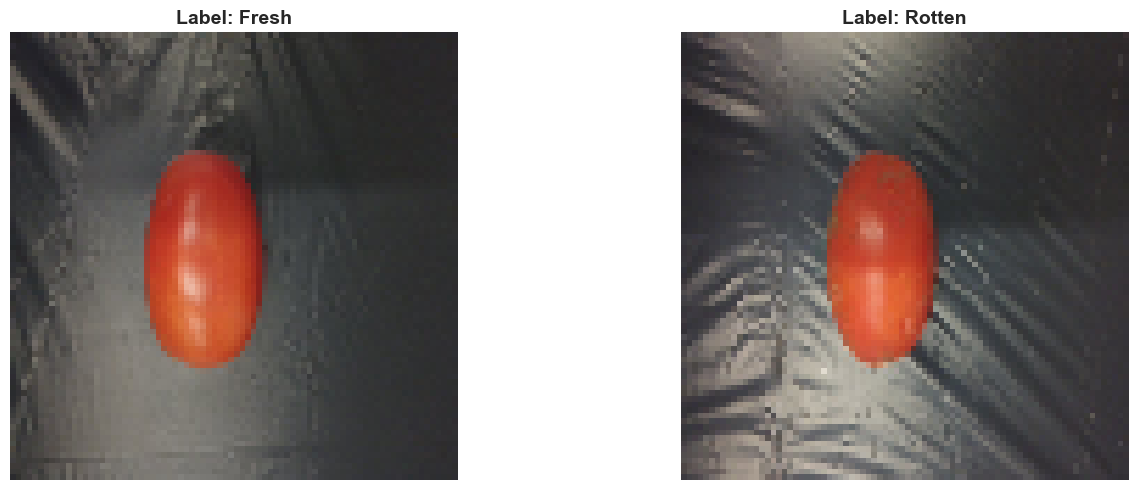

In [97]:
# Display Sample Images
categories = {"Fresh": 1, "Rotten": 0}
label_names = {0: "Rotten", 1: "Fresh"}

plt.figure(figsize=(15, 5))

for i, (category, label) in enumerate(random.sample(list(categories.items()), 2)):
    folder_path = os.path.join(DATASET_PATH, category)
    img_name = random.choice(os.listdir(folder_path))
    img_path = os.path.join(folder_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label_names[label]}", fontsize=14, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Logistic Regression Model**

In [ ]:
log_reg = LogisticRegression(
    C=0.1,
    max_iter=5000,
    solver='saga',
    penalty='l1',
    class_weight='balanced',
    random_state=42,
    tol=1e-3,
    n_jobs=-1,
    verbose=0
)

log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

# Check convergence
if log_reg.n_iter_[0] == log_reg.max_iter:
    print("WARNING: Model didn't converge!")
else:
    print(f"Model converged in {log_reg.n_iter_[0]} iterations")

In [43]:
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Rotten', 'Fresh']))

roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:,1])
print(f"ROC AUC: {roc_auc:.3f}")


Model Accuracy: 87.36%

Classification Report:
              precision    recall  f1-score   support

      Rotten       0.83      0.81      0.82       159
       Fresh       0.90      0.91      0.90       284

    accuracy                           0.87       443
   macro avg       0.86      0.86      0.86       443
weighted avg       0.87      0.87      0.87       443

ROC AUC: 0.944


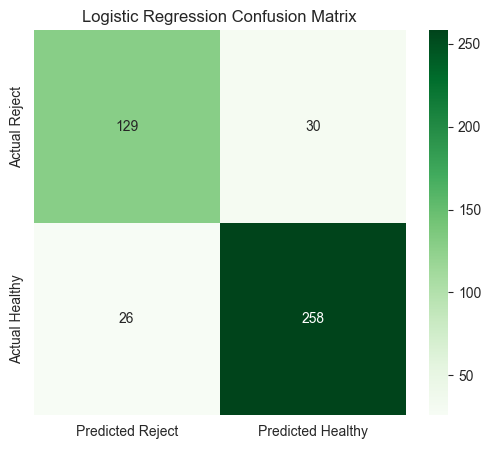

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Reject', 'Predicted Healthy'],
            yticklabels=['Actual Reject', 'Actual Healthy'])
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [45]:
#Cross Validation
cv_scores = cross_val_score(
    log_reg,
    X_train_scaled,
    y_train,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

print("Cross-Validation Results:")
print("CV Scores:", [f"{score:.4f}" for score in cv_scores])
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Cross-Validation Results:
CV Scores: ['0.8613', '0.8542', '0.8610']
Mean CV Accuracy: 0.8588 (+/- 0.0033)


In [46]:
#Feature Extraction Details
num_features = X.shape[1]

print("Feature Extraction Information:")
print("Method: HOG (Histogram of Oriented Gradients) + Color Statistics")
print(f"HOG Features: {num_features - 12}")
print(f"Color Features (BGR): 6")
print(f"Color Features (HSV): 6")
print(f"Total Features per Image: {num_features}")
print(f"Feature Vector Shape: {X.shape}")

Feature Extraction Information:
Method: HOG (Histogram of Oriented Gradients) + Color Statistics
HOG Features: 5862
Color Features (BGR): 6
Color Features (HSV): 6
Total Features per Image: 5874
Feature Vector Shape: (2214, 5874)


In [47]:
#Model Hyperparameter
print("Logistic Regression Hyperparameters:")
print(f"Model: Logistic Regression")
print(f"Solver: {log_reg.solver}")
print(f"Penalty: {log_reg.penalty}")
print(f"C (Inverse regularization): {log_reg.C}")
print(f"Max iterations: {log_reg.max_iter}")
print(f"Class weight: {log_reg.class_weight}")
print(f"Random state: {log_reg.random_state}")

Logistic Regression Hyperparameters:
Model: Logistic Regression
Solver: saga
Penalty: l1
C (Inverse regularization): 0.1
Max iterations: 5000
Class weight: balanced
Random state: 42


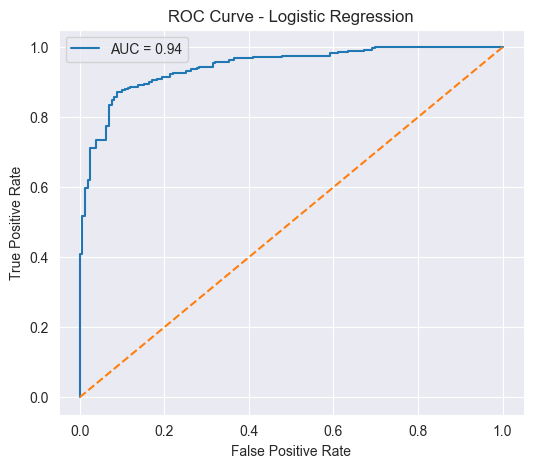

In [48]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

y_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


# **kmeans model**

In [1]:
# Cell 17 - K-Means: Data Preparation & PCA
print("K-MEANS CLUSTERING WITH PCA")

# Normalization
scaler_kmeans = StandardScaler()
X_scaled_kmeans = scaler_kmeans.fit_transform(X)

print(f"\nData Normalized")

# PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled_kmeans)

print(f"\nPCA Applied")
print(f"   Original features: {X.shape[1]}")
print(f"   Reduced features: {X_pca.shape[1]}")
print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.4f}")

K-MEANS CLUSTERING WITH PCA


NameError: name 'StandardScaler' is not defined

In [68]:
# K-Means: Training & Clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=100)
kmeans.fit(X_pca)
clusters = kmeans.labels_

sil_score = silhouette_score(X_pca, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.354


In [66]:
# K-Means: Mapping & Accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Map clusters to labels
mapping = {}
for cluster_id in np.unique(clusters):
    true_labels = y[clusters == cluster_id]
    mapped_label = np.bincount(true_labels).argmax()
    mapping[cluster_id] = mapped_label

y_pred_kmeans = np.array([mapping[c] for c in clusters])

# Accuracy
accuracy_kmeans = accuracy_score(y, y_pred_kmeans)
print(f"\nK-Means Accuracy: {accuracy_kmeans * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y, y_pred_kmeans, target_names=['Rotten', 'Fresh']))



K-Means Accuracy: 67.57%

Classification Report:
              precision    recall  f1-score   support

      Rotten       0.55      0.52      0.53       793
       Fresh       0.74      0.76      0.75      1421

    accuracy                           0.68      2214
   macro avg       0.65      0.64      0.64      2214
weighted avg       0.67      0.68      0.67      2214



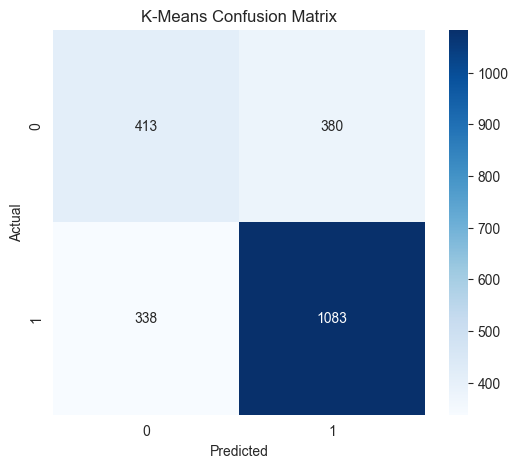

In [65]:
# K-Means: Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_k = confusion_matrix(y, y_pred_kmeans)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_k, annot=True, fmt='d', cmap='Blues')
plt.title('K-Means Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

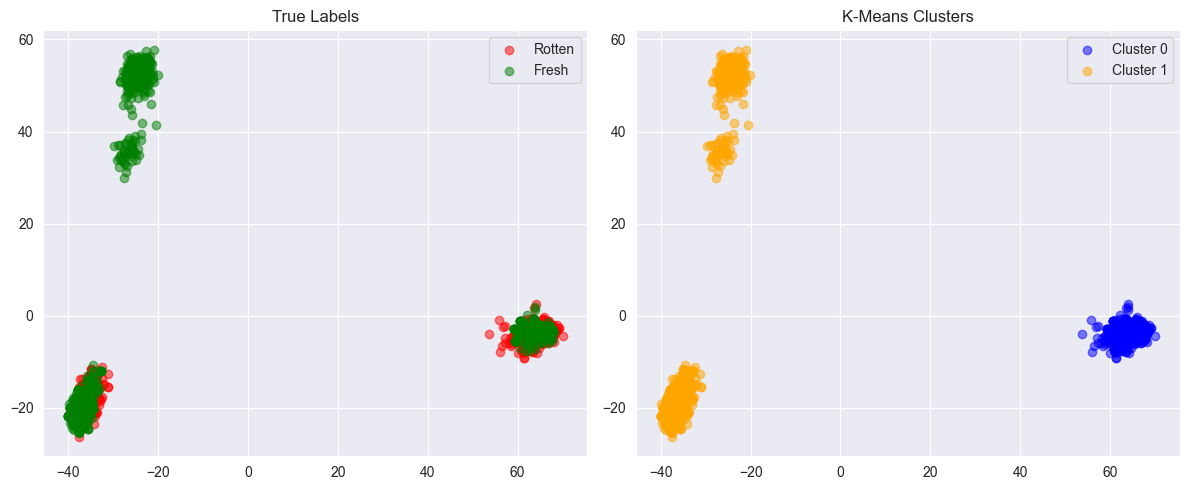

In [63]:
#K-Means: 2D Visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to 2D
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled_kmeans)

plt.figure(figsize=(12, 5))

# True Labels
plt.subplot(1, 2, 1)
plt.scatter(X_2d[y==0, 0], X_2d[y==0, 1], c='red', alpha=0.5, label='Rotten')
plt.scatter(X_2d[y==1, 0], X_2d[y==1, 1], c='green', alpha=0.5, label='Fresh')
plt.title('True Labels')
plt.legend()

# K-Means Clusters
plt.subplot(1, 2, 2)
plt.scatter(X_2d[clusters==0, 0], X_2d[clusters==0, 1], c='blue', alpha=0.5, label='Cluster 0')
plt.scatter(X_2d[clusters==1, 0], X_2d[clusters==1, 1], c='orange', alpha=0.5, label='Cluster 1')
plt.title('K-Means Clusters')
plt.legend()

plt.tight_layout()
plt.show()

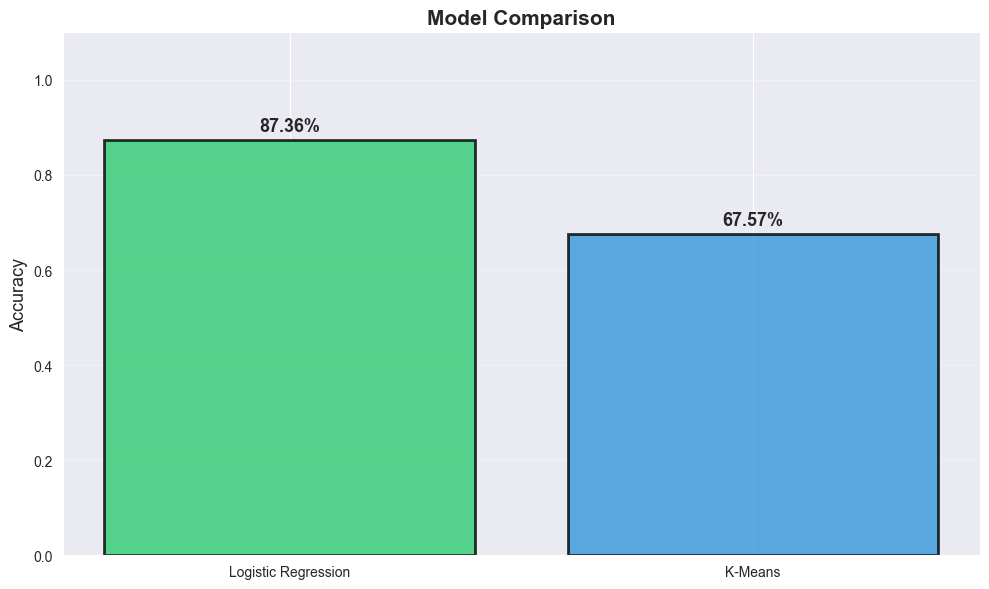

FINAL RESULTS
Logistic Regression: 87.36%
K-Means Clustering: 67.57%


In [64]:
#Final Comparison
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'K-Means']
accuracies = [accuracy, accuracy_kmeans]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#2ecc71', '#3498db'],
               alpha=0.8, edgecolor='black', linewidth=2)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc*100:.2f}%', ha='center', va='bottom',
             fontsize=13, fontweight='bold')

plt.ylabel('Accuracy', fontsize=13)
plt.title('Model Comparison', fontsize=15, fontweight='bold')
plt.ylim([0, 1.1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("FINAL RESULTS")
print(f"Logistic Regression: {accuracies[0]*100:.2f}%")
print(f"K-Means Clustering: {accuracies[1]*100:.2f}%")